<a href="https://www.kaggle.com/sdysch/nlp-disaster-tweets?scriptVersionId=88324181" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(df_train.columns)

df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print(df_test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [3]:
# preprocessing, lower case
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [4]:
# remove URLS
import re

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'', text)

df_train['text'] = df_train['text'].apply(remove_urls)
df_test['text']  = df_test['text'].apply(remove_urls)

In [5]:
# removing stop words
from nltk.corpus import stopwords
def remove_stopwords(text):
    sw = stopwords.words('english')
    words = text.split(' ')
    filtered = [w for w in words if w not in sw]
    return ' '.join([str(v) for v in filtered])

df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text']  = df_test['text'].apply(remove_stopwords)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 40
n_words = 100000
tokenizer = Tokenizer(oov_token='<OOV>', num_words=n_words)
tokenizer.fit_on_texts(df_train['text'])
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(df_train['text'])
training_padded = pad_sequences(training_sequences, padding='post', maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(df_test['text'])
testing_padded    = pad_sequences(testing_sequences, padding='post', maxlen=max_length)
print(training_padded.shape)
print(testing_padded.shape)

(7613, 40)
(3263, 40)


# LSTM model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, Dropout, Bidirectional
rnn_model = Sequential()
rnn_model.add(Embedding(n_words, 50))
#rnn_model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False)))
rnn_model.add(LSTM(50, activation='relu', return_sequences=True))
rnn_model.add(LSTM(20, activation='relu', return_sequences=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(10, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.summary()

2022-02-25 19:59:29.426314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 19:59:29.544669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 19:59:29.545507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 19:59:29.546796: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          5000000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          20200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,026,101
Trainable params: 5,026,101
Non-trainable params: 0
______________________________________________

In [8]:
# model is *really* prone to overfitting, only a few epochs needed
epochs = 4
batch_size = 32

y_train = df_train['target']

history = rnn_model.fit(training_padded,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          shuffle=True)

Epoch 1/4


2022-02-25 19:59:32.073737: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


191/191 [==============================] - 33s 157ms/step - loss: 0.7387 - accuracy: 0.5860 - val_loss: 0.6907 - val_accuracy: 0.5345
Epoch 2/4
191/191 [==============================] - 30s 157ms/step - loss: 0.6596 - accuracy: 0.6143 - val_loss: 0.6741 - val_accuracy: 0.5844
Epoch 3/4
191/191 [==============================] - 30s 159ms/step - loss: 0.5043 - accuracy: 0.7892 - val_loss: 0.5353 - val_accuracy: 0.7656
Epoch 4/4
191/191 [==============================] - 31s 162ms/step - loss: 0.3206 - accuracy: 0.9028 - val_loss: 0.5451 - val_accuracy: 0.7886


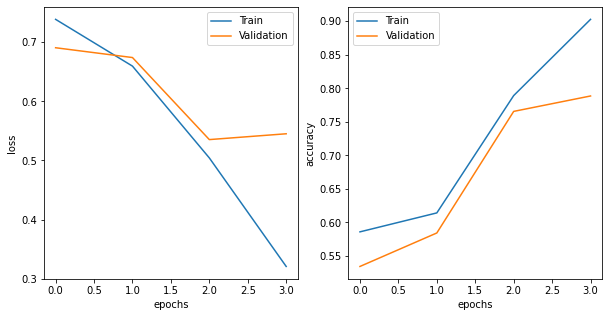

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(loc='best')


plt.show()

In [10]:
y_pred = rnn_model.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sub['target'] = y_pred.round(0).astype('int')
sub.to_csv('submission.csv', index=False)